# Phase 3: Behavioral State Classification for Estrous Detection

## Overview

**Objective:** Classify individual nights as "estrus-like" or "diestrus-like" based on behavioral features.

**Dataset:** JAX Envision Morph2REP (Study 1001, 2025v3.3)
- 18 female C57BL/6J mice (vehicle controls)
- 14-16 nights per animal
- Dark cycle behavioral bouts (6 PM - 6 AM EST)

---

## Literature Foundation: Khatiz et al. (2025)

**"Real-time behavioral monitoring of C57BL/6J mice during reproductive cycle"**  
*Frontiers in Neuroscience, 19:1509822*

### Key Behavioral Markers

| Estrus (High Estrogen) | Metestrus/Diestrus (Low Estrogen) |
|------------------------|-----------------------------------|
| 30% more physically demanding activity | Lower overall activity |
| Sustained activity bouts (low fragmentation) | Fragmented activity (more bouts) |
| Higher exploratory behavior | More sleep-related behavior |
| Lower feeding during dark cycle | Higher feeding/habituation |
| More locomotion bout counts | Fewer locomotion bouts |
| Less sleep fragmentation | More sleep fragmentation (more rousings) |

### Statistical Methods (Data-Driven, No Manual Weights)

1. **Standardization** - All features on equal footing
2. **Factor Analysis** - Identify underlying behavioral dimensions (loadings = data-derived weights)
3. **PCA** - Reduce dimensionality, find primary axes of differentiation
4. **K-Means Clustering** - Let data find natural groupings
5. **Hierarchical Clustering** - Alternative clustering for comparison

---

## References

1. Khatiz A, et al. (2025). Real-time behavioral monitoring of C57BL/6J mice during reproductive cycle. *Front. Neurosci.* 19:1509822.
2. Levy DR, et al. (2023). Mouse spontaneous behavior reflects individual variation rather than estrous state. *Curr Biol.* 33:1358-1364.

---
# Part 1: Setup and Configuration
---

In [1]:
# Install required packages
!pip install duckdb pyarrow umap-learn -q

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Statistical tools
from scipy import stats
from scipy.stats import shapiro, normaltest, ttest_ind
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# ML tools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score
import umap

print("All imports successful!")

2026-02-03 13:12:02.742983: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-03 13:12:02.743023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-03 13:12:02.744658: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-03 13:12:02.754390: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


All imports successful!


In [3]:
# Configuration
S3_BASE = "s3://jax-envision-public-data/study_1001/2025v3.3/tabular"

# Vehicle control cages (14-16 days of unconfounded baseline)
VEHICLE_CAGES = {
    'Rep1': {
        'cages': [4918, 4922, 4923],
        'start_date': '2025-01-07',
        'end_date': '2025-01-22',
    },
    'Rep2': {
        'cages': [4928, 4929, 4934],
        'start_date': '2025-01-22',
        'end_date': '2025-02-04',
    }
}

print("Configuration loaded!")
print(f"Vehicle cages: {[c for rep in VEHICLE_CAGES.values() for c in rep['cages']]}")

Configuration loaded!
Vehicle cages: [4918, 4922, 4923, 4928, 4929, 4934]


---
# Part 2: Data Loading
---

In [4]:
# Function to load animal_bouts.parquet
def load_bout_data(cage_id, start_date, end_date):
    """Load animal_bouts.parquet for a single cage across date range."""
    conn = duckdb.connect()
    conn.execute("INSTALL httpfs; LOAD httpfs;")
    conn.execute("SET s3_region='us-east-1';")
    
    dates = pd.date_range(start_date, end_date, freq='D')
    all_data = []
    
    for date in dates:
        date_str = date.strftime('%Y-%m-%d')
        path = f"{S3_BASE}/cage_id={cage_id}/date={date_str}/animal_bouts.parquet"
        
        try:
            df = conn.execute(f"SELECT * FROM read_parquet('{path}')").fetchdf()
            df['cage_id'] = cage_id
            df['date'] = date_str
            all_data.append(df)
        except:
            continue
    
    conn.close()
    
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    return pd.DataFrame()

# Function to load animal_bout_metrics.parquet (distance traveled)
def load_bout_metrics(cage_id, start_date, end_date):
    """Load animal_bout_metrics.parquet with distance traveled per bout."""
    conn = duckdb.connect()
    conn.execute("INSTALL httpfs; LOAD httpfs;")
    conn.execute("SET s3_region='us-east-1';")
    
    dates = pd.date_range(start_date, end_date, freq='D')
    all_data = []
    
    for date in dates:
        date_str = date.strftime('%Y-%m-%d')
        path = f"{S3_BASE}/cage_id={cage_id}/date={date_str}/animal_bout_metrics.parquet"
        
        try:
            df = conn.execute(f"SELECT * FROM read_parquet('{path}')").fetchdf()
            df['cage_id'] = cage_id
            df['date'] = date_str
            all_data.append(df)
        except:
            continue
    
    conn.close()
    
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    return pd.DataFrame()

In [5]:
# Load bout data for all vehicle control cages
print("Loading bout data (animal_bouts.parquet)...")
print("="*60)

all_bouts = []
for rep_name, rep_config in VEHICLE_CAGES.items():
    print(f"{rep_name}:")
    for cage_id in rep_config['cages']:
        print(f"  Cage {cage_id}...", end=" ")
        df = load_bout_data(cage_id, rep_config['start_date'], rep_config['end_date'])
        if len(df) > 0:
            df['replicate'] = rep_name
            all_bouts.append(df)
            print(f"{len(df):,} bouts")
        else:
            print("No data")

df_bouts = pd.concat(all_bouts, ignore_index=True)
print("="*60)
print(f"Total bouts loaded: {len(df_bouts):,}")

Loading bout data (animal_bouts.parquet)...
Rep1:
  Cage 4918... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

2,558,344 bouts
  Cage 4922... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

2,401,455 bouts
  Cage 4923... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

2,458,754 bouts
Rep2:
  Cage 4928... 2,259,981 bouts
  Cage 4929... 2,071,012 bouts
  Cage 4934... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

2,201,662 bouts
Total bouts loaded: 13,951,208


In [6]:
# Load bout metrics (distance traveled) for all vehicle control cages
print("Loading bout metrics (animal_bout_metrics.parquet)...")
print("="*60)

all_bout_metrics = []
for rep_name, rep_config in VEHICLE_CAGES.items():
    print(f"{rep_name}:")
    for cage_id in rep_config['cages']:
        print(f"  Cage {cage_id}...", end=" ")
        df = load_bout_metrics(cage_id, rep_config['start_date'], rep_config['end_date'])
        if len(df) > 0:
            df['replicate'] = rep_name
            all_bout_metrics.append(df)
            print(f"{len(df):,} rows")
        else:
            print("No data")

df_bout_metrics = pd.concat(all_bout_metrics, ignore_index=True)
print("="*60)
print(f"Total bout metrics loaded: {len(df_bout_metrics):,}")

Loading bout metrics (animal_bout_metrics.parquet)...
Rep1:
  Cage 4918... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

2,153,458 rows
  Cage 4922... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

2,114,699 rows
  Cage 4923... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

2,112,969 rows
Rep2:
  Cage 4928... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

1,967,936 rows
  Cage 4929... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

1,828,562 rows
  Cage 4934... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

1,945,821 rows
Total bout metrics loaded: 12,123,445


In [7]:
# Inspect the data
print("Bout data columns:", df_bouts.columns.tolist())
print("\nUnique state names (bouts):")
print(df_bouts['state_name'].unique())

print("\n" + "="*60)
print("Bout metrics columns:", df_bout_metrics.columns.tolist())
print("\nMetric names:", df_bout_metrics['metric_name'].unique())

print(f"\nUnique animals: {df_bouts['animal_id'].nunique()}")

Bout data columns: ['predicted_identity', 'start_time', 'end_time', 'state_name', 'organization_id', 'cage_id', 'study_id', 'device_id', 'animal_id', 'bout_length_seconds', 'source_file', 'date', 'replicate']

Unique state names (bouts):
['animal_bouts.active' 'animal_bouts.inactive' 'animal_bouts.feeding'
 'animal_bouts.drinking' 'animal_bouts.social.in_proximity_other'
 'animal_bouts.locomotion' 'animal_bouts.climbing'
 'animal_bouts.social.isolated_other' 'animal_bouts.social.isolated_all'
 'animal_bouts.social.proximal_all' 'animal_bouts.inferred_sleep']

Bout metrics columns: ['predicted_identity', 'start_time', 'end_time', 'state_name', 'organization_id', 'cage_id', 'study_id', 'device_id', 'animal_id', 'bout_length_seconds', 'metric_name', 'metric_agg', 'metric_value', 'source_file', 'date', 'replicate']

Metric names: ['animal.distance_travelled']

Unique animals: 19


---
# Part 3: Feature Engineering
---

In [8]:
def compute_nightly_summaries_with_exploration(df_bouts, df_bout_metrics):
    """
    Compute comprehensive nightly summaries including:
    - Duration metrics (from animal_bouts)
    - Bout count metrics (from animal_bouts)  
    - Exploration metrics (from animal_bout_metrics - distance traveled)
    """
    
    STATE_MAP = {
        'active': 'animal_bouts.active',
        'inactive': 'animal_bouts.inactive',
        'locomotion': 'animal_bouts.locomotion',
        'feeding': 'animal_bouts.feeding',
        'drinking': 'animal_bouts.drinking',
        'climbing': 'animal_bouts.climbing',
        'inferred_sleep': 'animal_bouts.inferred_sleep',
    }
    
    # ============================================
    # Process bouts data
    # ============================================
    df_bouts = df_bouts.copy()
    df_bouts['start_time'] = pd.to_datetime(df_bouts['start_time'])
    df_bouts['hour_utc'] = df_bouts['start_time'].dt.hour
    
    # Dark cycle: 6 PM - 6 AM EST = 23:00 - 11:00 UTC
    df_bouts['is_dark'] = (df_bouts['hour_utc'] >= 23) | (df_bouts['hour_utc'] < 11)
    
    # Night date assignment
    df_bouts['night_date'] = df_bouts['start_time'].dt.date
    mask_early = df_bouts['hour_utc'] < 11
    df_bouts.loc[mask_early, 'night_date'] = (
        pd.to_datetime(df_bouts.loc[mask_early, 'start_time']) - timedelta(days=1)
    ).dt.date
    
    df_dark = df_bouts[df_bouts['is_dark']].copy()
    
    # ============================================
    # Process bout metrics (distance traveled)
    # ============================================
    df_metrics = df_bout_metrics.copy()
    df_metrics['start_time'] = pd.to_datetime(df_metrics['start_time'])
    df_metrics['hour_utc'] = df_metrics['start_time'].dt.hour
    df_metrics['is_dark'] = (df_metrics['hour_utc'] >= 23) | (df_metrics['hour_utc'] < 11)
    
    df_metrics['night_date'] = df_metrics['start_time'].dt.date
    mask_early = df_metrics['hour_utc'] < 11
    df_metrics.loc[mask_early, 'night_date'] = (
        pd.to_datetime(df_metrics.loc[mask_early, 'start_time']) - timedelta(days=1)
    ).dt.date
    
    df_metrics_dark = df_metrics[df_metrics['is_dark']].copy()
    
    # ============================================
    # Aggregate bout-based metrics
    # ============================================
    print("Aggregating bout data...")
    results = []
    
    for (cage_id, animal_id, night_date), group in df_dark.groupby(['cage_id', 'animal_id', 'night_date']):
        row = {
            'cage_id': cage_id,
            'animal_id': animal_id,
            'night_date': night_date,
        }
        
        # Duration and bout count per state
        for short_name, full_name in STATE_MAP.items():
            state_data = group[group['state_name'] == full_name]
            row[f'{short_name}_duration'] = state_data['bout_length_seconds'].sum()
            row[f'{short_name}_bout_count'] = len(state_data)
            row[f'{short_name}_mean_bout'] = state_data['bout_length_seconds'].mean() if len(state_data) > 0 else 0
        
        row['total_dark_seconds'] = group['bout_length_seconds'].sum()
        results.append(row)
    
    df_summary = pd.DataFrame(results)
    
    # ============================================
    # Aggregate exploration metrics (distance traveled)
    # ============================================
    print("Aggregating exploration data...")
    exploration_results = []
    
    for (cage_id, animal_id, night_date), group in df_metrics_dark.groupby(['cage_id', 'animal_id', 'night_date']):
        row = {
            'cage_id': cage_id,
            'animal_id': animal_id,
            'night_date': night_date,
        }
        
        # Total distance traveled (all states)
        row['total_distance'] = group['metric_value'].sum()
        
        # Distance by state
        for short_name, full_name in STATE_MAP.items():
            state_data = group[group['state_name'] == full_name]
            row[f'{short_name}_distance'] = state_data['metric_value'].sum()
            row[f'{short_name}_distance_per_bout'] = state_data['metric_value'].mean() if len(state_data) > 0 else 0
        
        exploration_results.append(row)
    
    df_exploration = pd.DataFrame(exploration_results)
    
    # ============================================
    # Merge bout and exploration summaries
    # ============================================
    print("Merging data...")
    df_summary = df_summary.merge(
        df_exploration, 
        on=['cage_id', 'animal_id', 'night_date'], 
        how='left'
    )
    
    # ============================================
    # Compute derived features
    # ============================================
    
    # Activity metrics
    df_summary['activity_amplitude'] = df_summary['active_duration'] + df_summary['locomotion_duration']
    
    # Fragmentation metrics (bouts per unit time)
    df_summary['sleep_fragmentation'] = df_summary['inferred_sleep_bout_count'] / (df_summary['inferred_sleep_duration'] + 1)
    df_summary['active_fragmentation'] = df_summary['active_bout_count'] / (df_summary['active_duration'] + 1)
    
    # Ratios
    df_summary['feeding_ratio'] = df_summary['feeding_duration'] / (df_summary['active_duration'] + 1)
    df_summary['sleep_ratio'] = df_summary['inferred_sleep_duration'] / (df_summary['total_dark_seconds'] + 1)
    
    # Exploration metrics
    df_summary['exploration_intensity'] = df_summary['total_distance'] / (df_summary['activity_amplitude'] + 1)
    df_summary['locomotion_efficiency'] = df_summary['locomotion_distance'] / (df_summary['locomotion_duration'] + 1)
    
    return df_summary

In [9]:
# Compute nightly summaries
print("Computing nightly summaries with exploration metrics...")
print("="*60)
df_nightly = compute_nightly_summaries_with_exploration(df_bouts, df_bout_metrics)

# Filter out animal_id = 0 (tracking errors)
df_nightly = df_nightly[df_nightly['animal_id'] != 0].copy()

print("="*60)
print(f"Nightly summaries: {len(df_nightly)} animal-nights")
print(f"Animals: {df_nightly['animal_id'].nunique()}")

Computing nightly summaries with exploration metrics...
Aggregating bout data...
Aggregating exploration data...
Merging data...
Nightly summaries: 258 animal-nights
Animals: 18


In [10]:
# Inspect features
print("Feature Summary:")
print("="*70)

key_features = [
    'activity_amplitude', 'locomotion_duration', 'inactive_duration',
    'inferred_sleep_duration', 'feeding_duration', 'climbing_duration',
    'locomotion_bout_count', 'climbing_bout_count', 'active_mean_bout',
    'active_fragmentation', 'sleep_fragmentation',
    'total_distance', 'locomotion_distance', 'exploration_intensity'
]

for feat in key_features:
    if feat in df_nightly.columns:
        print(f"{feat:30}: mean={df_nightly[feat].mean():.2f}, std={df_nightly[feat].std():.2f}")

Feature Summary:
activity_amplitude            : mean=28167.59, std=5360.48
locomotion_duration           : mean=3274.83, std=1163.13
inactive_duration             : mean=9996.63, std=2644.30
inferred_sleep_duration       : mean=3650.58, std=1649.04
feeding_duration              : mean=2819.47, std=1313.45
climbing_duration             : mean=3403.23, std=1782.32
locomotion_bout_count         : mean=1648.73, std=516.04
climbing_bout_count           : mean=755.00, std=368.73
active_mean_bout              : mean=7.96, std=1.39
active_fragmentation          : mean=0.13, std=0.02
sleep_fragmentation           : mean=0.01, std=0.00
total_distance                : mean=58561.80, std=21644.41
locomotion_distance           : mean=12027.49, std=4634.39
exploration_intensity         : mean=2.11, std=0.80


---
# Part 4: Data-Driven Classification (Khatiz Method)
---

**Key principle:** NO manual weights. All features are standardized equally, and we let statistical methods (Factor Analysis, PCA, K-Means) find the natural structure in the data.

In [11]:
# Define features for analysis (based on Khatiz findings)
FEATURES_FOR_ANALYSIS = [
    # Duration metrics
    'activity_amplitude',
    'locomotion_duration', 
    'inactive_duration',
    'inferred_sleep_duration',
    'feeding_duration',
    'climbing_duration',
    
    # Bout metrics
    'locomotion_bout_count',
    'climbing_bout_count',
    'active_mean_bout',
    'active_fragmentation',
    'sleep_fragmentation',
    
    # Exploration metrics
    'total_distance',
    'locomotion_distance',
    'exploration_intensity',
]

# Prepare data - drop rows with missing values
df_analysis = df_nightly.dropna(subset=FEATURES_FOR_ANALYSIS).copy()
X = df_analysis[FEATURES_FOR_ANALYSIS].values

# STANDARDIZE (like Khatiz - puts all metrics on equal footing)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Data prepared: {X_scaled.shape[0]} nights × {X_scaled.shape[1]} features")
print(f"\nFeatures (all equally weighted after standardization):")
for f in FEATURES_FOR_ANALYSIS:
    print(f"  - {f}")

Data prepared: 258 nights × 14 features

Features (all equally weighted after standardization):
  - activity_amplitude
  - locomotion_duration
  - inactive_duration
  - inferred_sleep_duration
  - feeding_duration
  - climbing_duration
  - locomotion_bout_count
  - climbing_bout_count
  - active_mean_bout
  - active_fragmentation
  - sleep_fragmentation
  - total_distance
  - locomotion_distance
  - exploration_intensity


## 4.1 Factor Analysis (Data-Derived Loadings)

In [12]:
# Factor Analysis - let the DATA determine the weights (loadings)
n_factors = 3
fa = FactorAnalysis(n_components=n_factors, random_state=42)
fa.fit(X_scaled)

# Get loadings (these are DATA-DERIVED weights!)
loadings = pd.DataFrame(
    fa.components_.T,
    index=FEATURES_FOR_ANALYSIS,
    columns=[f'Factor_{i+1}' for i in range(n_factors)]
)

print("="*70)
print("FACTOR ANALYSIS LOADINGS (Data-Derived Weights)")
print("="*70)
print(loadings.round(3).to_string())

# Interpret factors
print("\n" + "="*70)
print("FACTOR INTERPRETATION:")
print("="*70)
for i in range(n_factors):
    col = f'Factor_{i+1}'
    print(f"\n{col}:")
    
    top_pos = loadings[col].nlargest(3)
    print(f"  HIGH: {', '.join([f'{idx} ({val:+.2f})' for idx, val in top_pos.items()])}")
    
    top_neg = loadings[col].nsmallest(3)
    print(f"  LOW:  {', '.join([f'{idx} ({val:+.2f})' for idx, val in top_neg.items()])}")

FACTOR ANALYSIS LOADINGS (Data-Derived Weights)
                         Factor_1  Factor_2  Factor_3
activity_amplitude          0.494    -0.437    -0.231
locomotion_duration         1.000     0.003    -0.009
inactive_duration           0.060    -0.995    -0.004
inferred_sleep_duration    -0.021    -0.825    -0.042
feeding_duration            0.215    -0.095     0.061
climbing_duration           0.476     0.021     0.831
locomotion_bout_count       0.981    -0.050    -0.020
climbing_bout_count         0.548     0.013     0.731
active_mean_bout           -0.739     0.229    -0.232
active_fragmentation        0.759    -0.138     0.252
sleep_fragmentation        -0.194     0.323     0.027
total_distance              0.758    -0.053     0.635
locomotion_distance         0.985     0.020     0.058
exploration_intensity       0.514     0.128     0.783

FACTOR INTERPRETATION:

Factor_1:
  HIGH: locomotion_duration (+1.00), locomotion_distance (+0.98), locomotion_bout_count (+0.98)
  LOW:  act

## 4.2 PCA (Principal Components)

In [13]:
# PCA - standardized, no manual weights
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Add PCA coordinates to dataframe
for i in range(5):
    df_analysis[f'PC{i+1}'] = X_pca[:, i]

print("="*70)
print("PCA RESULTS")
print("="*70)
print(f"\nVariance explained:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {var*100:.1f}%")
print(f"  Total (5 PCs): {sum(pca.explained_variance_ratio_)*100:.1f}%")

# PCA loadings
pca_loadings = pd.DataFrame(
    pca.components_.T,
    index=FEATURES_FOR_ANALYSIS,
    columns=[f'PC{i+1}' for i in range(5)]
)
print("\nPCA Loadings (first 3 components):")
print(pca_loadings[['PC1', 'PC2', 'PC3']].round(3).to_string())

PCA RESULTS

Variance explained:
  PC1: 49.2%
  PC2: 18.1%
  PC3: 10.6%
  PC4: 8.2%
  PC5: 5.7%
  Total (5 PCs): 91.8%

PCA Loadings (first 3 components):
                           PC1    PC2    PC3
activity_amplitude      -0.145 -0.399 -0.342
locomotion_duration     -0.338 -0.067 -0.317
inactive_duration       -0.058 -0.504  0.283
inferred_sleep_duration -0.009 -0.503  0.394
feeding_duration        -0.101 -0.206 -0.026
climbing_duration       -0.296  0.185  0.346
locomotion_bout_count   -0.336 -0.111 -0.318
climbing_bout_count     -0.316  0.148  0.265
active_mean_bout         0.325  0.023  0.036
active_fragmentation    -0.328  0.042 -0.022
sleep_fragmentation      0.074  0.372 -0.198
total_distance          -0.358  0.078  0.155
locomotion_distance     -0.342 -0.039 -0.270
exploration_intensity   -0.293  0.264  0.345


## 4.3 K-Means Clustering (Find Natural Groups)

In [14]:
# K-Means - let algorithm find natural clusters
print("="*70)
print("K-MEANS CLUSTERING")
print("="*70)

# Try different k values
print(f"\n{'k':<5} {'Silhouette':<12} {'Interpretation'}")
print("-"*45)

silhouettes = []
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    silhouettes.append(sil)
    
    if k == 2:
        interp = "High vs Low activity?"
    elif k == 4:
        interp = "4 estrous phases?"
    else:
        interp = ""
    print(f"{k:<5} {sil:<12.3f} {interp}")

optimal_k = range(2, 7)[np.argmax(silhouettes)]
print(f"\nOptimal k by silhouette: {optimal_k}")

K-MEANS CLUSTERING

k     Silhouette   Interpretation
---------------------------------------------
2     0.272        High vs Low activity?
3     0.331        
4     0.227        4 estrous phases?
5     0.201        
6     0.189        

Optimal k by silhouette: 3


In [15]:
# Apply K-Means with k=2 for binary classification
kmeans_2 = KMeans(n_clusters=2, random_state=42, n_init=10)
df_analysis['kmeans_cluster'] = kmeans_2.fit_predict(X_scaled)

# Determine which cluster is "estrus-like" based on activity
cluster_means = df_analysis.groupby('kmeans_cluster')[FEATURES_FOR_ANALYSIS].mean()
print("\nCluster means (key features):")
print(cluster_means[['activity_amplitude', 'total_distance', 'inactive_duration', 'inferred_sleep_duration']].round(1))

# Higher activity cluster = estrus-like
estrus_cluster = cluster_means['activity_amplitude'].idxmax()
df_analysis['kmeans_state'] = df_analysis['kmeans_cluster'].apply(
    lambda x: 'Estrus-like' if x == estrus_cluster else 'Diestrus-like'
)

km_counts = df_analysis['kmeans_state'].value_counts()
print(f"\nK-Means Classification (k=2):")
print(f"  Estrus-like:   {km_counts.get('Estrus-like', 0)} ({100*km_counts.get('Estrus-like', 0)/len(df_analysis):.1f}%)")
print(f"  Diestrus-like: {km_counts.get('Diestrus-like', 0)} ({100*km_counts.get('Diestrus-like', 0)/len(df_analysis):.1f}%)")


Cluster means (key features):
                activity_amplitude  total_distance  inactive_duration  \
kmeans_cluster                                                          
0                          28054.7         45488.5            10158.9   
1                          28329.4         77308.4             9764.0   

                inferred_sleep_duration  
kmeans_cluster                           
0                                3863.2  
1                                3345.7  

K-Means Classification (k=2):
  Estrus-like:   106 (41.1%)
  Diestrus-like: 152 (58.9%)


## 4.4 Hierarchical Clustering

In [16]:
# Hierarchical clustering with Ward linkage
print("="*70)
print("HIERARCHICAL CLUSTERING")
print("="*70)

linkage_matrix = linkage(X_scaled, method='ward')

# Cut at k=2
hc_labels = fcluster(linkage_matrix, 2, criterion='maxclust')
df_analysis['hc_cluster'] = hc_labels

# Determine which cluster is estrus-like
hc_means = df_analysis.groupby('hc_cluster')[FEATURES_FOR_ANALYSIS].mean()
hc_estrus = hc_means['activity_amplitude'].idxmax()

df_analysis['hc_state'] = df_analysis['hc_cluster'].apply(
    lambda x: 'Estrus-like' if x == hc_estrus else 'Diestrus-like'
)

hc_counts = df_analysis['hc_state'].value_counts()
print(f"\nHierarchical Classification (k=2):")
print(f"  Estrus-like:   {hc_counts.get('Estrus-like', 0)} ({100*hc_counts.get('Estrus-like', 0)/len(df_analysis):.1f}%)")
print(f"  Diestrus-like: {hc_counts.get('Diestrus-like', 0)} ({100*hc_counts.get('Diestrus-like', 0)/len(df_analysis):.1f}%)")

HIERARCHICAL CLUSTERING

Hierarchical Classification (k=2):
  Estrus-like:   207 (80.2%)
  Diestrus-like: 51 (19.8%)


## 4.5 Compare Classification Methods

In [17]:
# Compare classifications from different methods
print("="*70)
print("COMPARISON OF DATA-DRIVEN CLASSIFICATION METHODS")
print("="*70)

print("\nClassification Distribution:")
print("-"*50)
km_pct = 100 * (df_analysis['kmeans_state'] == 'Estrus-like').sum() / len(df_analysis)
hc_pct = 100 * (df_analysis['hc_state'] == 'Estrus-like').sum() / len(df_analysis)
print(f"  K-Means:       {km_pct:.1f}% Estrus-like")
print(f"  Hierarchical:  {hc_pct:.1f}% Estrus-like")
print(f"  Expected:      ~25% (biological expectation)")

# Agreement between methods
print("\n" + "-"*50)
print("Method Agreement:")
km_binary = (df_analysis['kmeans_state'] == 'Estrus-like').astype(int)
hc_binary = (df_analysis['hc_state'] == 'Estrus-like').astype(int)
ari = adjusted_rand_score(km_binary, hc_binary)
print(f"  K-Means vs Hierarchical: ARI = {ari:.3f}")
print(f"  (ARI: 1.0 = perfect agreement, 0 = random)")

# Cross-tabulation
print("\nCross-tabulation:")
print(pd.crosstab(df_analysis['kmeans_state'], df_analysis['hc_state']))

# Use K-Means as primary classification
df_analysis['estrous_state'] = df_analysis['kmeans_state']
print(f"\n→ Using K-Means as primary classification")

COMPARISON OF DATA-DRIVEN CLASSIFICATION METHODS

Classification Distribution:
--------------------------------------------------
  K-Means:       41.1% Estrus-like
  Hierarchical:  80.2% Estrus-like
  Expected:      ~25% (biological expectation)

--------------------------------------------------
Method Agreement:
  K-Means vs Hierarchical: ARI = 0.320
  (ARI: 1.0 = perfect agreement, 0 = random)

Cross-tabulation:
hc_state       Diestrus-like  Estrus-like
kmeans_state                             
Diestrus-like              0          152
Estrus-like               51           55

→ Using K-Means as primary classification


---
# Part 5: Validation
---

In [18]:
# Validate that classified groups differ on key features
print("="*70)
print("CLASSIFICATION VALIDATION")
print("="*70)

estrus_df = df_analysis[df_analysis['estrous_state'] == 'Estrus-like']
diestrus_df = df_analysis[df_analysis['estrous_state'] == 'Diestrus-like']

# Features to validate (based on Khatiz findings)
validation_features = [
    ('activity_amplitude', 'Higher in Estrus'),
    ('locomotion_duration', 'Higher in Estrus'),
    ('total_distance', 'Higher in Estrus'),
    ('locomotion_distance', 'Higher in Estrus'),
    ('climbing_duration', 'Higher in Estrus'),
    ('exploration_intensity', 'Higher in Estrus'),
    ('locomotion_bout_count', 'Higher in Estrus'),
    ('active_mean_bout', 'Higher in Estrus'),
    ('inactive_duration', 'Lower in Estrus'),
    ('inferred_sleep_duration', 'Lower in Estrus'),
    ('feeding_duration', 'Lower in Estrus'),
    ('active_fragmentation', 'Lower in Estrus'),
    ('sleep_fragmentation', 'Lower in Estrus'),
]

print(f"\n{'Feature':<25} {'Estrus':<12} {'Diestrus':<12} {'p-value':<12} {'Expected?'}")
print("-"*75)

sig_count = 0
correct_count = 0

for feat, expected in validation_features:
    if feat not in df_analysis.columns:
        continue
    
    e_vals = estrus_df[feat].dropna()
    d_vals = diestrus_df[feat].dropna()
    
    e_mean = e_vals.mean()
    d_mean = d_vals.mean()
    _, p_val = ttest_ind(e_vals, d_vals)
    
    if 'Higher' in expected:
        correct = e_mean > d_mean
    else:
        correct = e_mean < d_mean
    
    dir_mark = "✓" if correct else "✗"
    sig_mark = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
    
    if p_val < 0.05:
        sig_count += 1
    if correct:
        correct_count += 1
    
    print(f"{feat:<25} {e_mean:<12.2f} {d_mean:<12.2f} {p_val:<12.4f} {dir_mark} {sig_mark}")

print("-"*75)
print(f"Significant (p<0.05): {sig_count}/{len(validation_features)}")
print(f"Correct direction:    {correct_count}/{len(validation_features)}")

CLASSIFICATION VALIDATION

Feature                   Estrus       Diestrus     p-value      Expected?
---------------------------------------------------------------------------
activity_amplitude        28329.41     28054.74     0.6864       ✓ 
locomotion_duration       4178.69      2644.51      0.0000       ✓ ***
total_distance            77308.36     45488.53     0.0000       ✓ ***
locomotion_distance       15684.51     9477.19      0.0000       ✓ ***
climbing_duration         4767.00      2452.18      0.0000       ✓ ***
exploration_intensity     2.78         1.64         0.0000       ✓ ***
locomotion_bout_count     2039.51      1376.21      0.0000       ✓ ***
active_mean_bout          6.85         8.74         0.0000       ✗ ***
inactive_duration         9763.97      10158.88     0.2387       ✓ 
inferred_sleep_duration   3345.65      3863.23      0.0128       ✓ *
feeding_duration          2858.08      2792.55      0.6942       ✗ 
active_fragmentation      0.15         0.12         

---
# Part 6: Visualizations
---

In [19]:
# UMAP embedding
print("Computing UMAP embedding...")
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_scaled)
df_analysis['UMAP1'] = X_umap[:, 0]
df_analysis['UMAP2'] = X_umap[:, 1]
print("Done!")

Computing UMAP embedding...
Done!


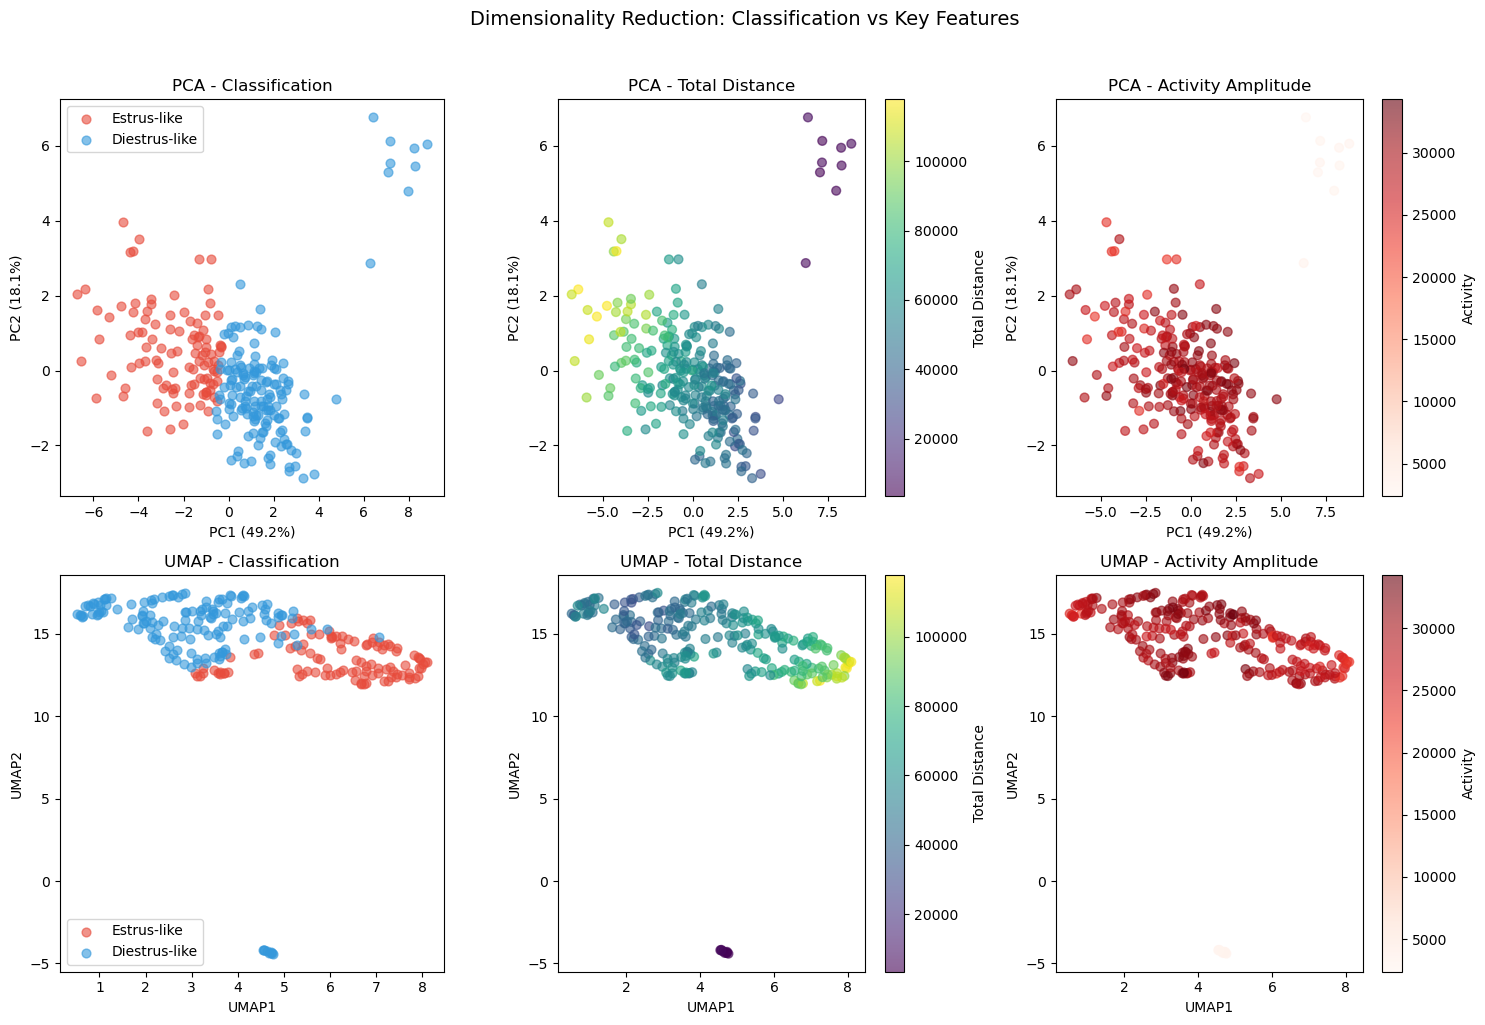

In [20]:
# Visualize classification in PCA and UMAP space
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: PCA
ax = axes[0, 0]
for state, color in [('Estrus-like', '#e74c3c'), ('Diestrus-like', '#3498db')]:
    mask = df_analysis['estrous_state'] == state
    ax.scatter(df_analysis.loc[mask, 'PC1'], df_analysis.loc[mask, 'PC2'],
               c=color, label=state, alpha=0.6, s=40)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('PCA - Classification')
ax.legend()

ax = axes[0, 1]
scatter = ax.scatter(df_analysis['PC1'], df_analysis['PC2'],
                     c=df_analysis['total_distance'], cmap='viridis', alpha=0.6, s=40)
plt.colorbar(scatter, ax=ax, label='Total Distance')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('PCA - Total Distance')

ax = axes[0, 2]
scatter = ax.scatter(df_analysis['PC1'], df_analysis['PC2'],
                     c=df_analysis['activity_amplitude'], cmap='Reds', alpha=0.6, s=40)
plt.colorbar(scatter, ax=ax, label='Activity')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('PCA - Activity Amplitude')

# Row 2: UMAP
ax = axes[1, 0]
for state, color in [('Estrus-like', '#e74c3c'), ('Diestrus-like', '#3498db')]:
    mask = df_analysis['estrous_state'] == state
    ax.scatter(df_analysis.loc[mask, 'UMAP1'], df_analysis.loc[mask, 'UMAP2'],
               c=color, label=state, alpha=0.6, s=40)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('UMAP - Classification')
ax.legend()

ax = axes[1, 1]
scatter = ax.scatter(df_analysis['UMAP1'], df_analysis['UMAP2'],
                     c=df_analysis['total_distance'], cmap='viridis', alpha=0.6, s=40)
plt.colorbar(scatter, ax=ax, label='Total Distance')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('UMAP - Total Distance')

ax = axes[1, 2]
scatter = ax.scatter(df_analysis['UMAP1'], df_analysis['UMAP2'],
                     c=df_analysis['activity_amplitude'], cmap='Reds', alpha=0.6, s=40)
plt.colorbar(scatter, ax=ax, label='Activity')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('UMAP - Activity Amplitude')

plt.suptitle('Dimensionality Reduction: Classification vs Key Features', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

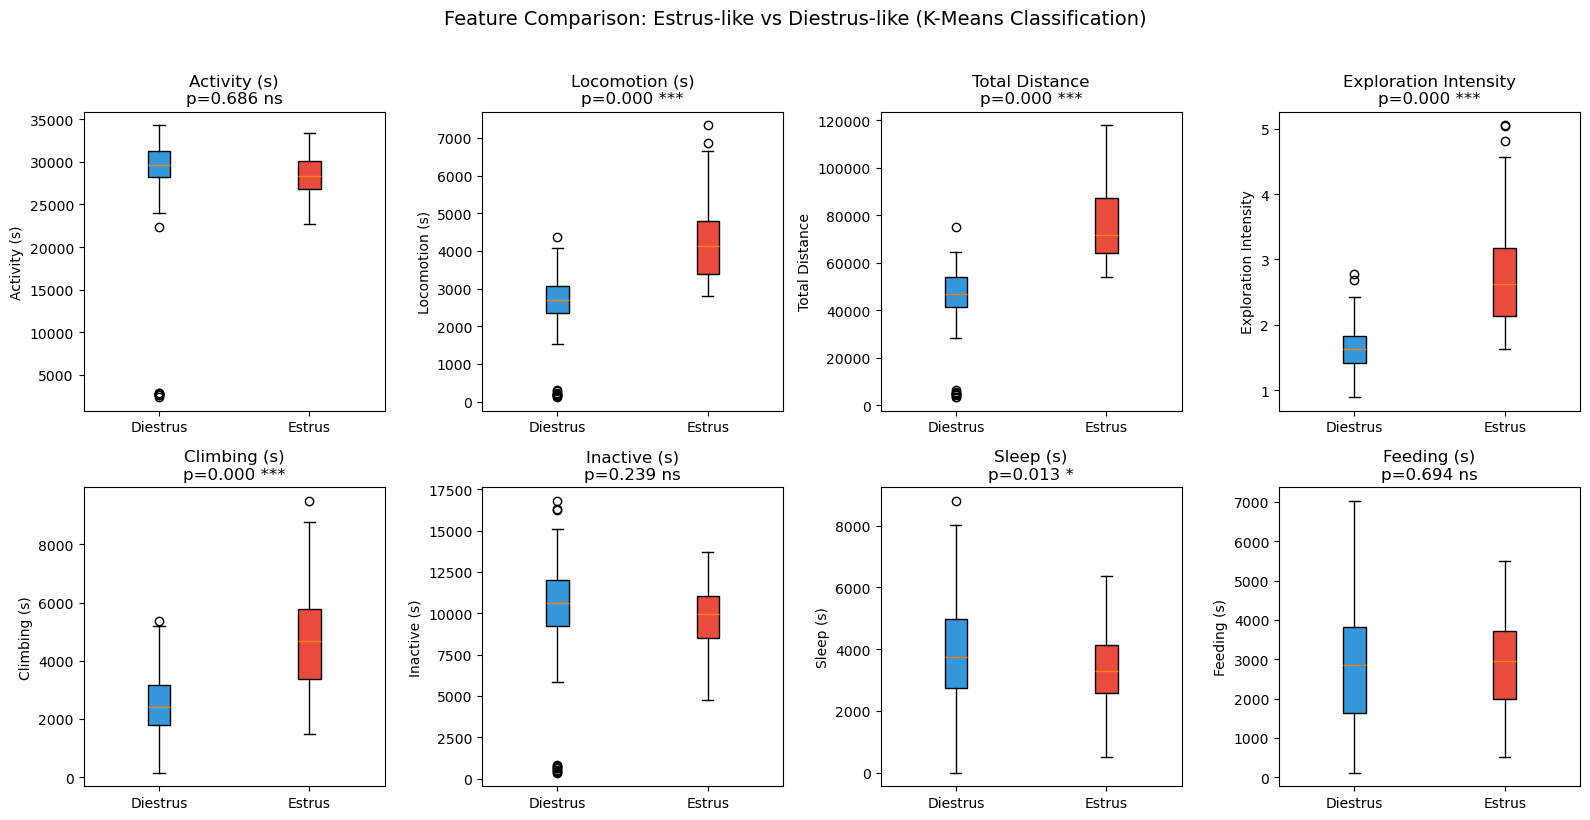

In [21]:
# Feature comparison boxplots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

features_to_plot = [
    ('activity_amplitude', 'Activity (s)'),
    ('locomotion_duration', 'Locomotion (s)'),
    ('total_distance', 'Total Distance'),
    ('exploration_intensity', 'Exploration Intensity'),
    ('climbing_duration', 'Climbing (s)'),
    ('inactive_duration', 'Inactive (s)'),
    ('inferred_sleep_duration', 'Sleep (s)'),
    ('feeding_duration', 'Feeding (s)'),
]

for idx, (feat, label) in enumerate(features_to_plot):
    ax = axes[idx]
    
    data = [df_analysis[df_analysis['estrous_state'] == 'Diestrus-like'][feat],
            df_analysis[df_analysis['estrous_state'] == 'Estrus-like'][feat]]
    
    bp = ax.boxplot(data, labels=['Diestrus', 'Estrus'], patch_artist=True)
    bp['boxes'][0].set_facecolor('#3498db')
    bp['boxes'][1].set_facecolor('#e74c3c')
    
    _, p_val = ttest_ind(data[0].dropna(), data[1].dropna())
    sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'
    
    ax.set_ylabel(label)
    ax.set_title(f'{label}\np={p_val:.3f} {sig}')

plt.suptitle('Feature Comparison: Estrus-like vs Diestrus-like (K-Means Classification)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

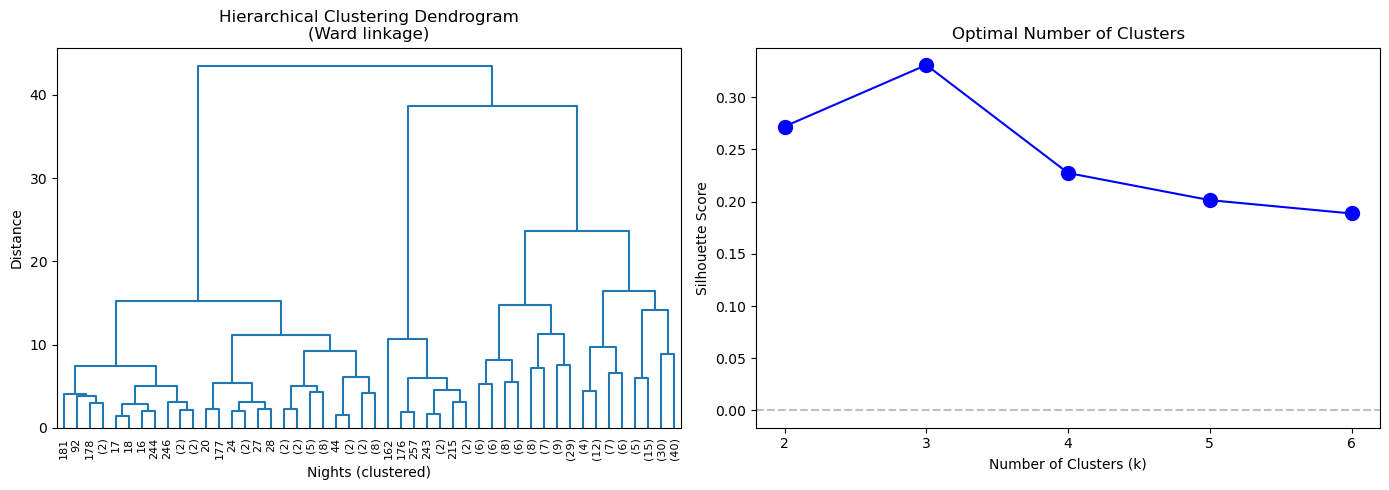

In [22]:
# Hierarchical clustering dendrogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Dendrogram
ax = axes[0]
dendrogram(linkage_matrix, ax=ax, truncate_mode='level', p=5,
           leaf_rotation=90, leaf_font_size=8, color_threshold=0)
ax.set_xlabel('Nights (clustered)')
ax.set_ylabel('Distance')
ax.set_title('Hierarchical Clustering Dendrogram\n(Ward linkage)')

# Silhouette scores for different k
ax = axes[1]
ax.plot(range(2, 7), silhouettes, 'bo-', markersize=10)
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Silhouette Score')
ax.set_title('Optimal Number of Clusters')
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xticks(range(2, 7))

plt.tight_layout()
plt.show()

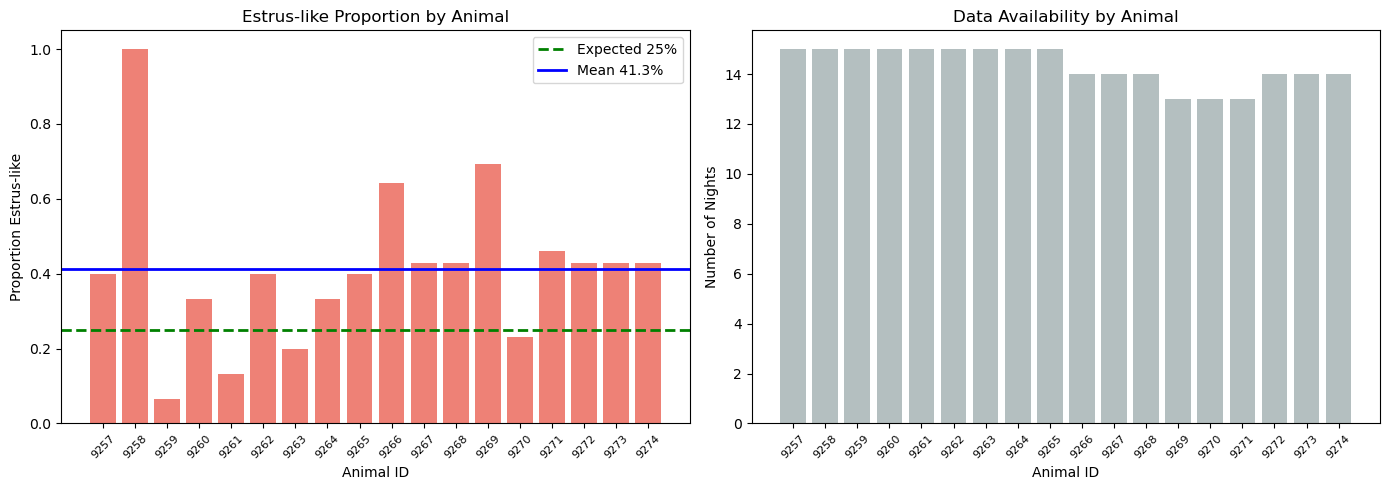

In [23]:
# Per-animal classification summary
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Proportion estrus-like by animal
ax = axes[0]
estrus_prop = df_analysis.groupby('animal_id').apply(
    lambda x: (x['estrous_state'] == 'Estrus-like').mean()
)
ax.bar(range(len(estrus_prop)), estrus_prop.values, color='#e74c3c', alpha=0.7)
ax.axhline(0.25, color='green', linestyle='--', linewidth=2, label='Expected 25%')
ax.axhline(estrus_prop.mean(), color='blue', linestyle='-', linewidth=2, label=f'Mean {estrus_prop.mean()*100:.1f}%')
ax.set_xticks(range(len(estrus_prop)))
ax.set_xticklabels([str(aid)[-4:] for aid in estrus_prop.index], rotation=45, fontsize=8)
ax.set_xlabel('Animal ID')
ax.set_ylabel('Proportion Estrus-like')
ax.set_title('Estrus-like Proportion by Animal')
ax.legend()

# Nights per animal
ax = axes[1]
nights_per_animal = df_analysis.groupby('animal_id').size()
ax.bar(range(len(nights_per_animal)), nights_per_animal.values, color='#95a5a6', alpha=0.7)
ax.set_xticks(range(len(nights_per_animal)))
ax.set_xticklabels([str(aid)[-4:] for aid in nights_per_animal.index], rotation=45, fontsize=8)
ax.set_xlabel('Animal ID')
ax.set_ylabel('Number of Nights')
ax.set_title('Data Availability by Animal')

plt.tight_layout()
plt.show()

---
# Part 7: Summary and Save Results
---

In [24]:
# Final summary
n_total = len(df_analysis)
n_estrus = (df_analysis['estrous_state'] == 'Estrus-like').sum()
pct_estrus = 100 * n_estrus / n_total

print("="*70)
print("PHASE 3: BEHAVIORAL STATE CLASSIFICATION - FINAL SUMMARY")
print("="*70)

print(f"""
DATASET:
--------
• Animals: {df_analysis['animal_id'].nunique()} female C57BL/6J mice (vehicle controls)
• Nights: {n_total} (dark cycle only)
• Features: {len(FEATURES_FOR_ANALYSIS)} behavioral metrics

METHOD:
-------
• Data-driven classification (no manual weights)
• All features standardized equally
• K-Means clustering (k=2) to find natural groups
• Groups labeled based on activity level

CLASSIFICATION RESULTS:
-----------------------
• Estrus-like nights:   {n_estrus:3d} ({pct_estrus:.1f}%)
• Diestrus-like nights: {n_total-n_estrus:3d} ({100-pct_estrus:.1f}%)
• Expected: ~25% estrus-like

VALIDATION:
-----------
• Significant features (p<0.05): {sig_count}/{len(validation_features)}
• Correct direction: {correct_count}/{len(validation_features)}
""")

print("KEY CAVEAT:")
print("-"*70)
print("Without vaginal cytology ground truth, classifications represent")
print("'estrus-like' and 'diestrus-like' behavioral patterns, not confirmed")
print("estrous phases. Validation is based on expected feature differences")
print("reported by Khatiz et al. (2025).")

PHASE 3: BEHAVIORAL STATE CLASSIFICATION - FINAL SUMMARY

DATASET:
--------
• Animals: 18 female C57BL/6J mice (vehicle controls)
• Nights: 258 (dark cycle only)
• Features: 14 behavioral metrics

METHOD:
-------
• Data-driven classification (no manual weights)
• All features standardized equally
• K-Means clustering (k=2) to find natural groups
• Groups labeled based on activity level

CLASSIFICATION RESULTS:
-----------------------
• Estrus-like nights:   106 (41.1%)
• Diestrus-like nights: 152 (58.9%)
• Expected: ~25% estrus-like

VALIDATION:
-----------
• Significant features (p<0.05): 9/13
• Correct direction: 10/13

KEY CAVEAT:
----------------------------------------------------------------------
Without vaginal cytology ground truth, classifications represent
'estrus-like' and 'diestrus-like' behavioral patterns, not confirmed
estrous phases. Validation is based on expected feature differences
reported by Khatiz et al. (2025).


In [25]:
# Save results
output_file = 'phase3_estrous_classifications.csv'
df_analysis.to_csv(output_file, index=False)
print(f"Results saved to: {output_file}")

# Summary by animal
summary = df_analysis.groupby('animal_id').agg({
    'estrous_state': lambda x: (x == 'Estrus-like').sum(),
    'night_date': 'count',
}).reset_index()
summary.columns = ['animal_id', 'n_estrus', 'n_nights']
summary['pct_estrus'] = 100 * summary['n_estrus'] / summary['n_nights']

print("\nPer-Animal Summary:")
print(summary.to_string(index=False))

summary_file = 'phase3_animal_summary.csv'
summary.to_csv(summary_file, index=False)
print(f"\nAnimal summary saved to: {summary_file}")

Results saved to: phase3_estrous_classifications.csv

Per-Animal Summary:
 animal_id  n_estrus  n_nights  pct_estrus
      9257         6        15   40.000000
      9258        15        15  100.000000
      9259         1        15    6.666667
      9260         5        15   33.333333
      9261         2        15   13.333333
      9262         6        15   40.000000
      9263         3        15   20.000000
      9264         5        15   33.333333
      9265         6        15   40.000000
      9266         9        14   64.285714
      9267         6        14   42.857143
      9268         6        14   42.857143
      9269         9        13   69.230769
      9270         3        13   23.076923
      9271         6        13   46.153846
      9272         6        14   42.857143
      9273         6        14   42.857143
      9274         6        14   42.857143

Animal summary saved to: phase3_animal_summary.csv


In [26]:
# Display final dataframe info
print("\nFinal DataFrame Info:")
print(f"Shape: {df_analysis.shape}")
print(f"\nKey columns:")
key_cols = ['cage_id', 'animal_id', 'night_date', 'estrous_state', 
            'activity_amplitude', 'total_distance', 'locomotion_duration']
print(df_analysis[key_cols].head(10))


Final DataFrame Info:
Shape: (258, 59)

Key columns:
    cage_id  animal_id  night_date  estrous_state  activity_amplitude  \
15     4918       9257  2025-01-07  Diestrus-like               22306   
16     4918       9257  2025-01-08    Estrus-like               27980   
17     4918       9257  2025-01-09    Estrus-like               26203   
18     4918       9257  2025-01-10    Estrus-like               27444   
19     4918       9257  2025-01-11    Estrus-like               29792   
20     4918       9257  2025-01-12    Estrus-like               31232   
21     4918       9257  2025-01-13  Diestrus-like               27838   
22     4918       9257  2025-01-14  Diestrus-like               29192   
23     4918       9257  2025-01-15  Diestrus-like               27758   
24     4918       9257  2025-01-16  Diestrus-like               27584   

    total_distance  locomotion_duration  
15    53932.042311                 2350  
16    63958.695433                 2866  
17    64893.6892